# Conversion Rates Case study

We want to optimise conversion rates on our site.
The goal is to come up with a model that is a useful predictor 
for conversion rates and try and then come up with proposals to try and increase
revenue.

Our data contains 6 columns where the converted column is what we want to predict.
Other variables include the country the user is from, their age, whether
they are a new user or not, what lead them to the site (source) and
finally the total number of pages visited.

In [191]:
import numpy as np
import pandas as pd
from sklearn.ensemble.partial_dependence import plot_partial_dependence
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize']=(10,10)

In [95]:
data = pd.read_csv("conversion_data.csv")
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [13]:
data['source'].describe() 

count     316200
unique         3
top          Seo
freq      155040
Name: source, dtype: object

In [3]:
# proportion of converted people
converted_rate = float(100*(data['converted'].loc[data['converted'] == 1].count())/(data.shape[0]))
print("Rate of conversion is {}%".format(round(converted_rate,2)))

Rate of conversion is 3.0%


## We have a conversion rate of 3 per cent which is very low. This means that just by predicting nobody converts, our model would be 97 per cent accurate. This is obviously not very good for this particular case so we need to deal with this unbalanced class in some way later. We could undersample our over sample as a way of improving the model.

## We will also need to use a different metric such as an F1-score or an ROC curve to assess how good our model is rather than accuracy

## Graphs
lets do graphs of all variables against converted variable

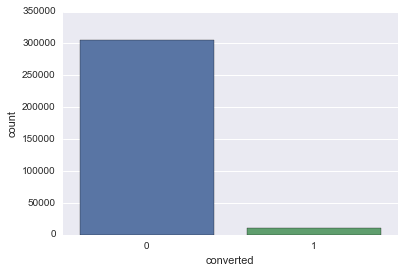

In [59]:
sns.countplot(x = "converted", data = data)
# looking at this we have very unbalanced classes so we may have to rebalance
# classes by either getting rid of observations or by creating pseudo data

In [4]:
# function to plot categorical data against outcome
def cat_plot(data,x):
    temp = pd.crosstab(x, data["converted"])
    plot = temp.plot(kind = 'bar', stacked=True, figsize=(9, 7))
    return [plot,temp]

[<matplotlib.axes._subplots.AxesSubplot at 0x1254f748>, converted       0     1
 country                
 China       76500   102
 Germany     12240   816
 UK          45900  2550
 US         171360  6732]

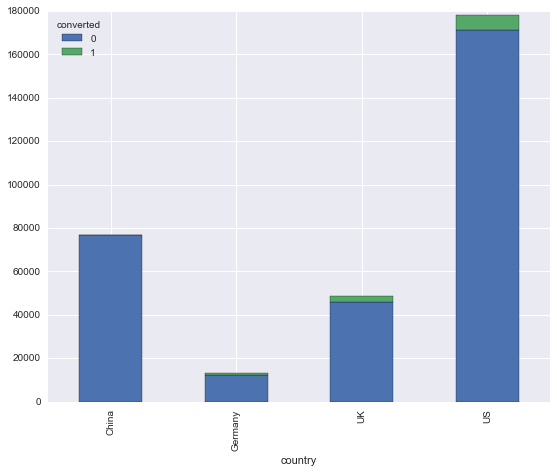

In [65]:
# country use bar chart
# age stacked histogram
# new user bar chart
# source stacked bar chart
# total_page_visits histo
cat_plot(data,data.country)


The majority of people do not convert but those who do seem to be from the 
UK or the US

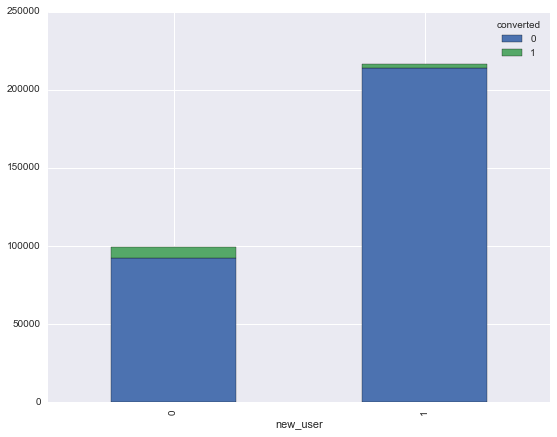

In [55]:
cat_plot(data, data.new_user)

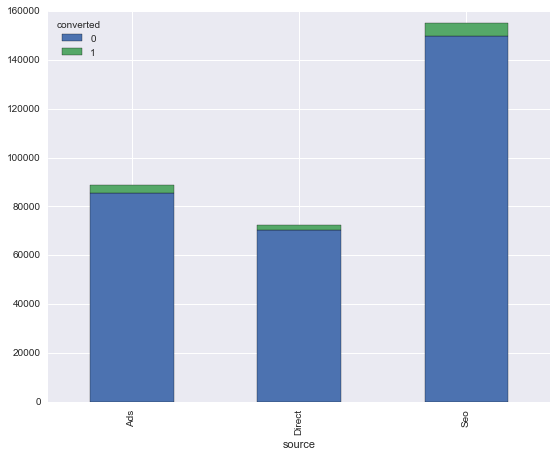

In [60]:
cat_plot(data, data.source)

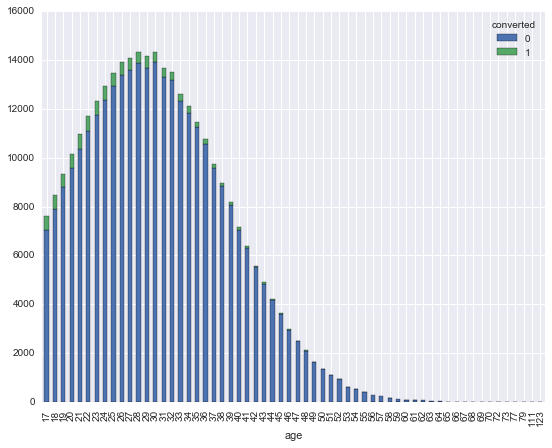

In [63]:
cat_plot(data,data.age)
# younger people tend to be more likey to convert

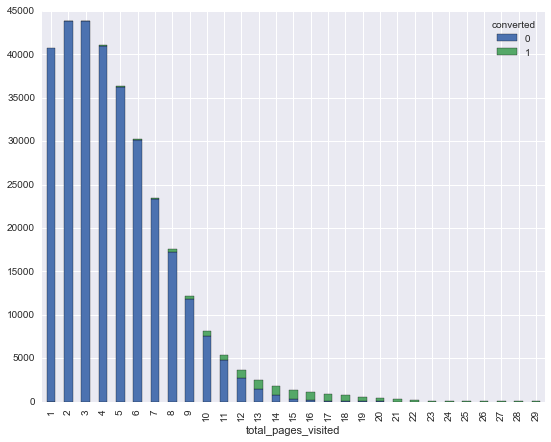

In [66]:
cat_plot(data, data.total_pages_visited)
# the more pages visited the higher chance of conversion

In [72]:
data.groupby('country')['age'].mean()
data.groupby('total_pages_visited')['age'].mean()

total_pages_visited
1     30.711701
2     30.701673
3     30.690251
4     30.729572
5     30.629476
6     30.666369
7     30.692737
8     30.625214
9     30.604343
10    30.632772
11    30.246385
12    29.491563
13    29.112577
14    28.278851
15    27.799245
16    27.221818
17    26.978698
18    26.734072
19    26.860177
20    26.446914
21    26.347973
22    26.488889
23    26.522124
24    26.152174
25    25.051282
26    25.529412
27    22.571429
28    17.000000
29    32.000000
Name: age, dtype: float64

In [87]:
# get data where converted == 1 and groupby country and see average age and page visited
# there isnt really anything standing out here
data[data["converted"] == 1].groupby('country')['age', 'total_pages_visited'].median()

,age,total_pages_visited
country,,
China,25.0,14.0
Germany,25.5,14.0
UK,25.0,14.0
US,25.0,15.0


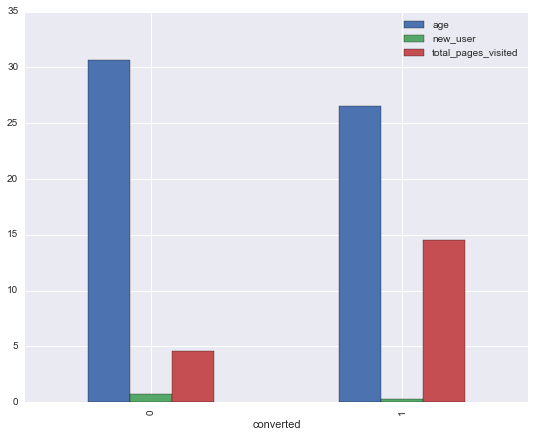

In [5]:
data.groupby('converted').median()
# this tells us that converted tend to be younger, new_users = 0 and visit more pages
data.groupby('converted').median().plot(kind = 'bar', figsize=(9, 7))

## Violin Plots

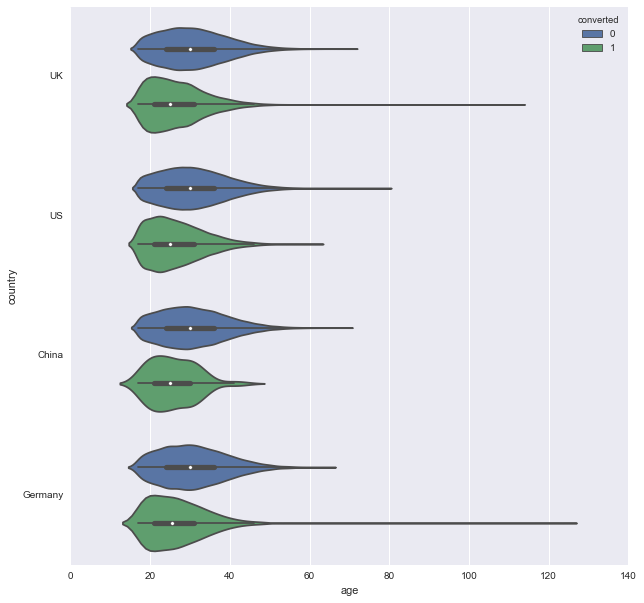

In [162]:
sns.violinplot(x="age", y="country", hue="converted", data=data)

## Try grouping by mean converted - gives us conversion rate and then plotting - may be an easier visualisation

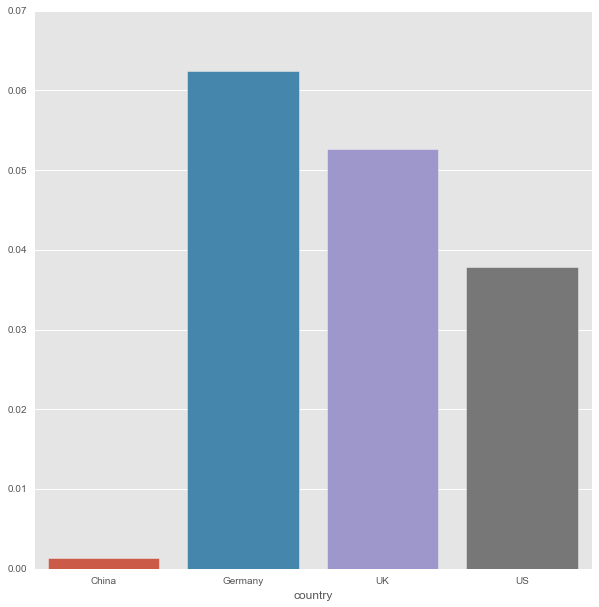

In [46]:
country_rate = data.groupby('country')['converted'].mean()

sns.barplot(x = country_rate.index, y = country_rate.values)
# Clearly China has a much lower rate of conversion than the other countries

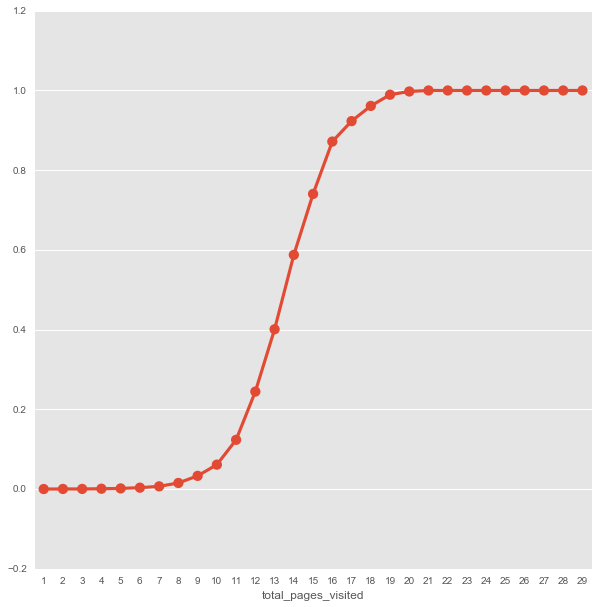

In [49]:
# do line plot of conversion rate versus total pages visited
total_pages_rate = data.groupby('total_pages_visited')['converted'].mean()
sns.pointplot(x = total_pages_rate.index, y = total_pages_rate.values)

We can see that as total pages visited increase you are much more likely to convert.
In fact once you view 19 or more pages you always convert.

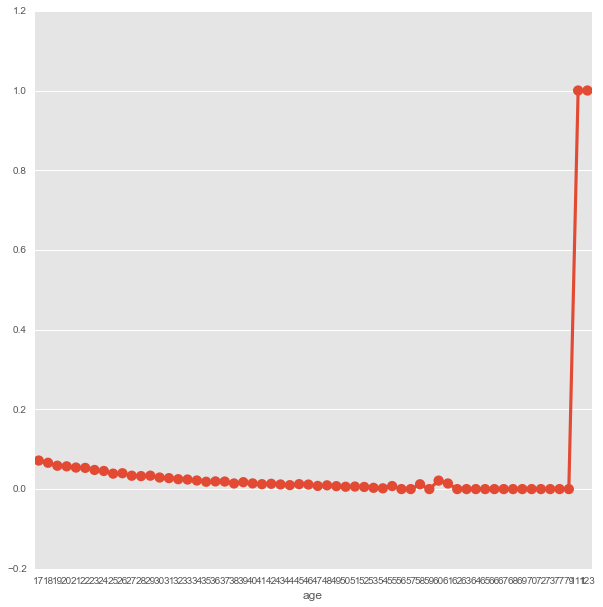

In [54]:
## now for age
age_rate = data.groupby('age')['converted'].mean()
age_rate
sns.pointplot(x = age_rate.index, y = age_rate.values)
# looks like two big outliers which we will deal with later

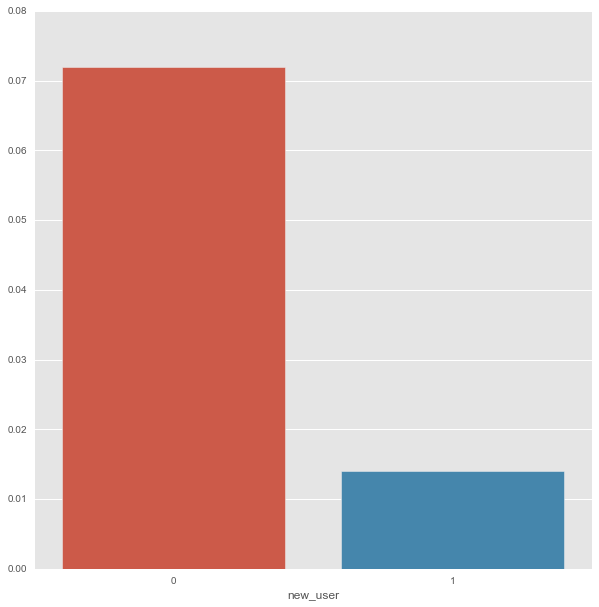

In [58]:
new_user_rate = data.groupby('new_user')['converted'].mean()
new_user_rate
sns.barplot(x = new_user_rate.index, y = new_user_rate.values)


### This plot indicates that new_user = 0, i.e. old users are far more likely to convert

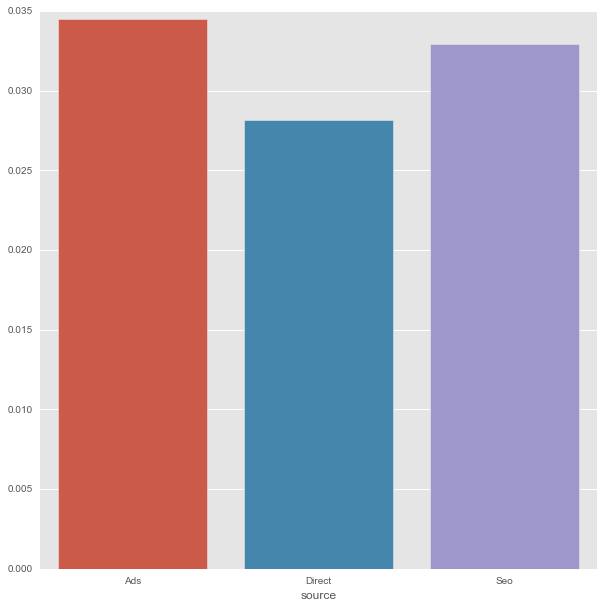

In [60]:
## now for source
source_rate = data.groupby('source')['converted'].mean()
source_rate
sns.barplot(x = source_rate.index, y = source_rate.values)
# not a huge amount of variation here suggesting that how people get to the site
# doesnt have a big impact on whether they convert or not.

## Next we need to deal with class imbalances. First We will undersample the larger class until the class distribution is around half and half to balance the data

In [96]:
converted_data = data[data['converted'] == 1]
non_converted_data = data[data['converted'] == 0]
print("number of converted: {}".format(len(converted_data)))
print("number of non converted: {}".format(len(non_converted_data)))

number of converted: 10200
number of non converted: 306000


### There are fewer converted so we will find the ratio of converted to non converted and use that percentage to undersample to non converted observations

In [97]:
perc = len(converted_data)/float(len(non_converted_data))
convert = converted_data
non_convert = non_converted_data.sample(frac = perc)

# append together
new_data = non_convert.append(convert)
new_data.shape

(20400, 6)

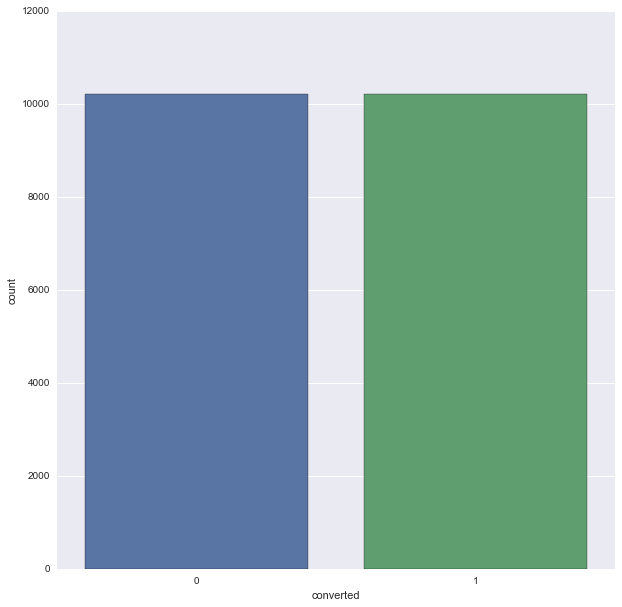

In [128]:
## lets see the distribution of classes now
sns.countplot(x = "converted", data = new_data)

## Our classes are now balanced

## Let's produce the plots aobve again this time with our new balanced data
## the patterns and relationships are now much clearer than before

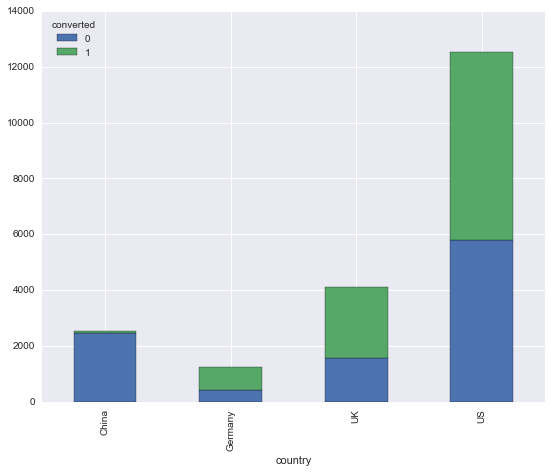

In [47]:
# plots with new data
cat_plot(new_data,new_data.country)

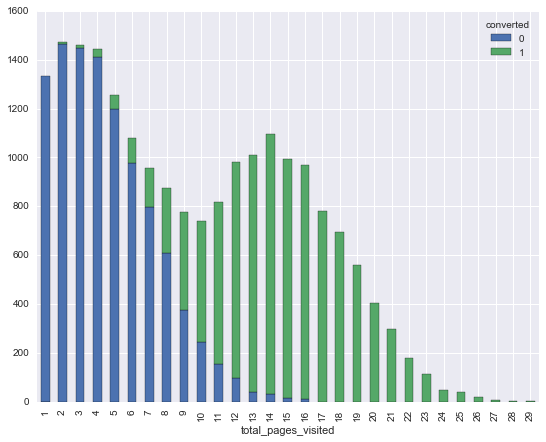

In [49]:
cat_plot(new_data, new_data.total_pages_visited)

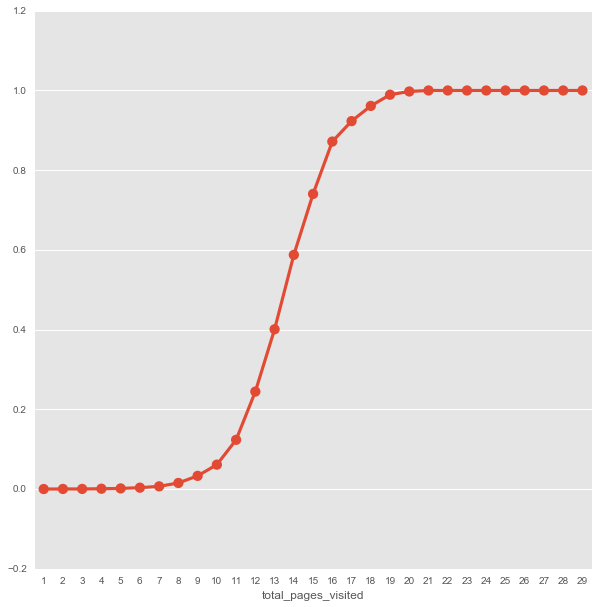

In [66]:
# alternate plot of essentially the same thing
temp = data.groupby('total_pages_visited')['converted'].mean()
sns.pointplot(x = temp.index, y = temp.values)

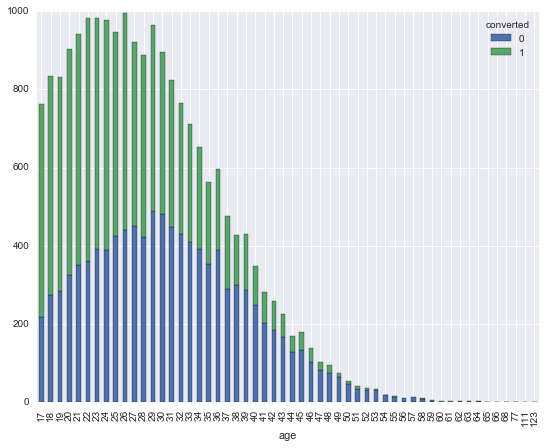

In [50]:
cat_plot(new_data,new_data.age)

[<matplotlib.axes._subplots.AxesSubplot at 0x124c3780>, converted     0     1
 new_user             
 0          3042  7161
 1          7158  3039]

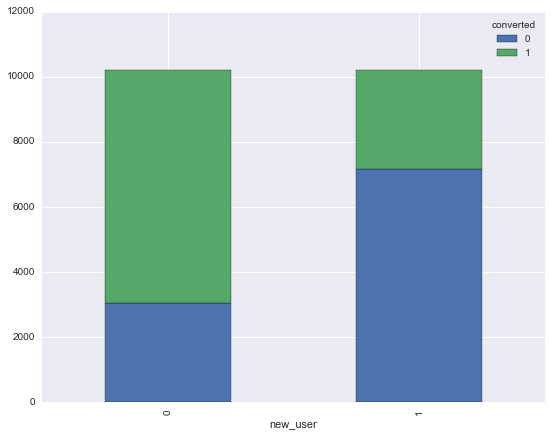

In [69]:
cat_plot(new_data,new_data.new_user)

In [54]:
new_data.head()

,country,age,new_user,source,total_pages_visited,converted
215224,US,50,1,Direct,3,0
114539,China,27,0,Ads,8,0
79505,UK,24,1,Seo,7,0
70561,US,26,1,Direct,2,0
80135,China,34,0,Seo,1,0


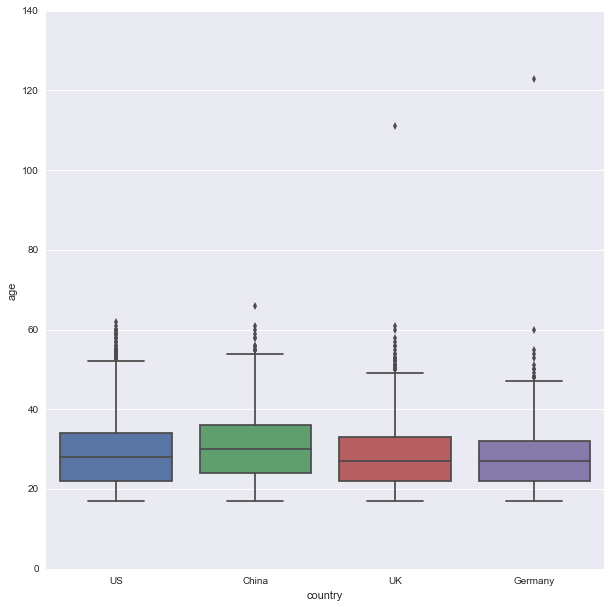

In [129]:
sns.boxplot(x="country", y="age", data=new_data)
## I doubt there is a 120 year old in Germany using this and similarly a 110
## year old in the UK so I will probably impute these

## Fix outliers in Age - replace with average of average age for country and new_user age

In [98]:
# lets look at the data for these elderly folks
new_data[new_data['age'] > 100]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


(26.546764705882353, 27.73872640125208)


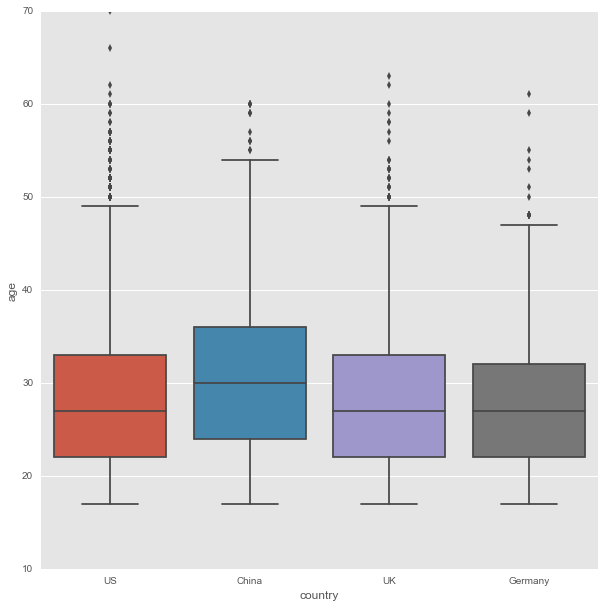

In [99]:
# average age for converted
avg_age_converted = new_data[new_data['converted'] == 1]['age'].mean()
avg_age_new_user =  new_data[new_data['new_user'] == 0]['age'].mean()
print(avg_age_converted, avg_age_new_user)

# replace with average of these two
new_age = (avg_age_converted + avg_age_new_user)/2

## have to get index first or else get an error
row_index = new_data['age'] > 100
new_data.loc[row_index, 'age'] = new_age
sns.boxplot(x="country", y="age", data=new_data)

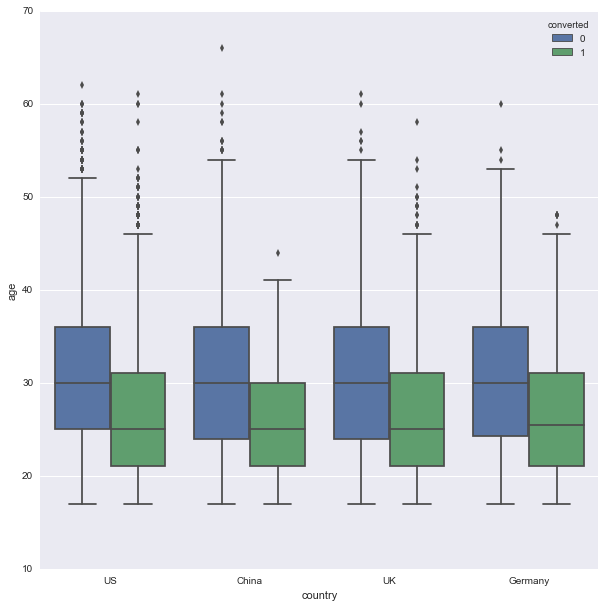

In [153]:
sns.boxplot(x="country", y="age", hue = 'converted', data=new_data)
# this tells us that converted people are virtually the same age across countries
# but they tend to be much younger than those who do not convert.

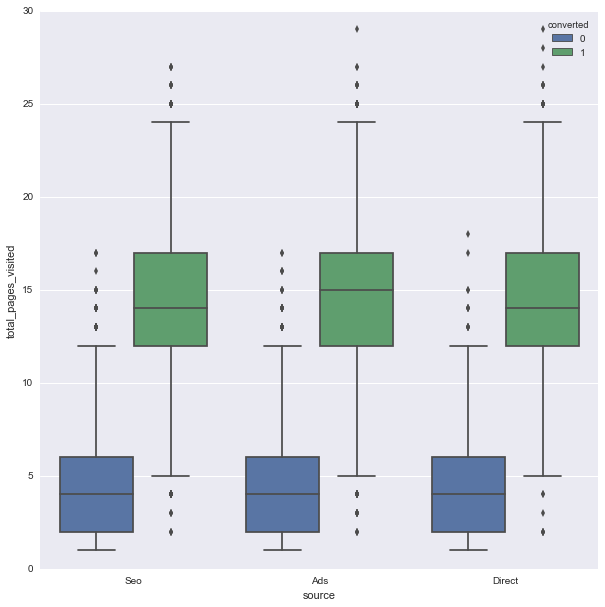

In [156]:
sns.boxplot(x="source", y="total_pages_visited", hue = 'converted', data=new_data)
# people who convert have considerably more page visits than those who don note convert

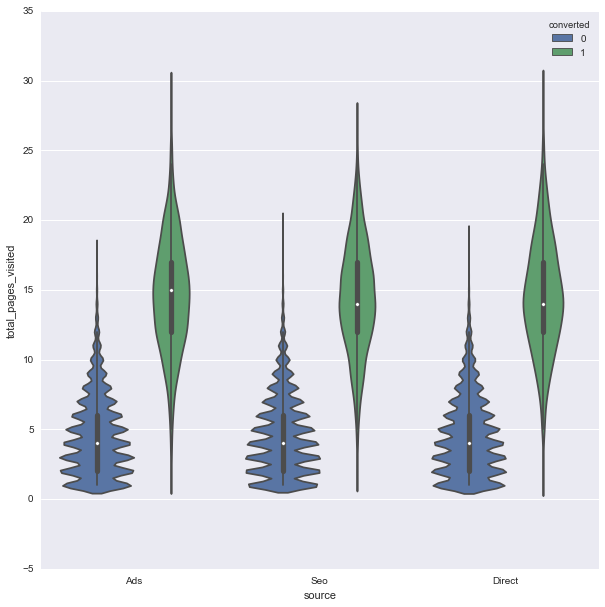

In [158]:
## Violin plots
sns.violinplot(x="source", y="total_pages_visited", hue="converted", data=data)

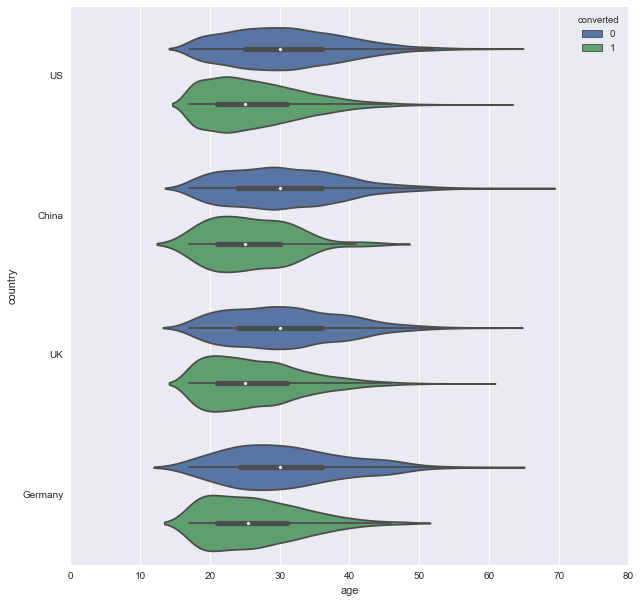

In [161]:
sns.violinplot(x="age", y="country", hue="converted", data=new_data)

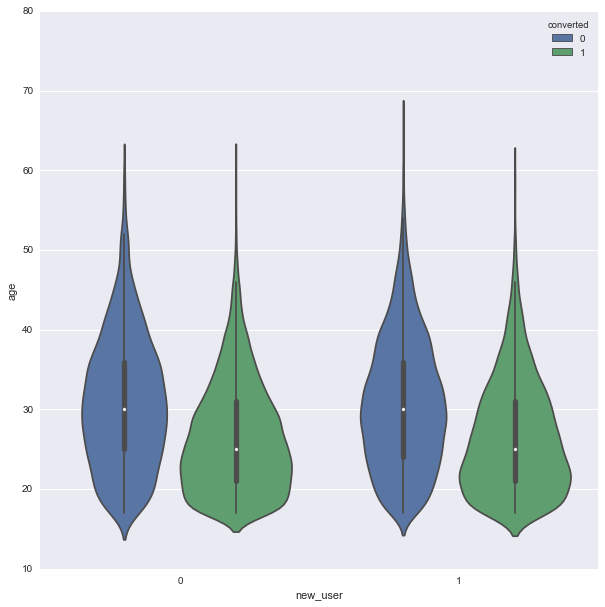

In [164]:
sns.violinplot(x="new_user", y="age", hue="converted", data=new_data)

## Overall it looks like the characteristics across countries are very similar for people who
## convert and those who do not.

In [7]:
data.dtypes

country                object
age                     int64
new_user                int64
source                 object
total_pages_visited     int64
converted               int64
dtype: object

## Data Preprocessing

* transform variables to dummies by one-hot encoding
* scale age variable
* label encoder on country and source
* split into train and test set for validation 

We want to transform our variables into forms that are handled better
by algorithms. Often by doing this we can get an increase in accuracy.

In [100]:
# loop through and turn categorical objects into numeric values
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()
for var in new_data.columns:
    if new_data[var].dtypes == 'object':
        le.fit(new_data[var].values)
        new_data[var] = le.transform(new_data[var])


In [72]:
## one hot encoding
#Source_dum = pd.get_dummies(new_data['source'], prefix = 'Source')
#Country_dum = pd.get_dummies(new_data['source'], prefix = 'Country')
#new_data = pd.concat([new_data, Source_dum, Country_dum], axis=1)

In [101]:
new_data.head()

,country,age,new_user,source,total_pages_visited,converted
252894,3,30.0,1,0,3,0
252139,3,42.0,1,0,4,0
301654,3,28.0,1,0,8,0
2616,3,29.0,1,1,1,0
233294,0,21.0,0,1,4,0


In [173]:
features = ['age', 'country','new_user', 'source', 'total_pages_visited']
           
target = ['converted']

In [174]:
## Train test split
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_data[features],
                                    new_data[target], test_size=0.3, 
                                    random_state=0)

In [175]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((14280, 5), (6120, 5), (14280, 1), (6120, 1))


In [176]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
#log=LogisticRegression(penalty='l2',C=.01)

# initialise model
model1 = LogisticRegression()

# need to turn y into 1d array for sklearn
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

# train model
model1.fit(X_train,y_train)
model1.score(X_train,y_train)

0.93648459383753502

### Our model is pretty accurate at 93.5% on the training set

In [177]:
y_train.mean()

0.50042016806722689

In [178]:
## Predict probabilities using test set for an ROC curve
probs = model1.predict_proba(X_test)
preds = model1.predict(X_test)
print probs, preds

[[  9.99594303e-01   4.05696599e-04]
 [  9.56534998e-01   4.34650020e-02]
 [  1.14107521e-02   9.88589248e-01]
 ..., 
 [  9.66044004e-01   3.39559959e-02]
 [  9.99197603e-01   8.02396942e-04]
 [  1.37979605e-03   9.98620204e-01]] [0 0 1 ..., 0 0 1]


In [179]:
## assess accuracy
print metrics.roc_auc_score(y_test, probs[:, 1])

0.984440059362


In [180]:
# lets have a look at the coefficients
pd.DataFrame(zip(X_train.columns, np.transpose(model1.coef_)))

,0,1
0,age,[-0.0713387695222]
1,country,[0.503931511036]
2,new_user,[-1.73819926627]
3,source,[0.00139762680801]
4,total_pages_visited,[0.755131174291]


## As mentioned before the accuracy metric may not be the best so lets use the F1 score which is a weighted average of the precision and recall

In [181]:
print(metrics.classification_report(y_true=y_test,
                              y_pred=preds) )

             precision    recall  f1-score   support

          0       0.94      0.93      0.94      3066
          1       0.93      0.94      0.94      3054

avg / total       0.94      0.94      0.94      6120



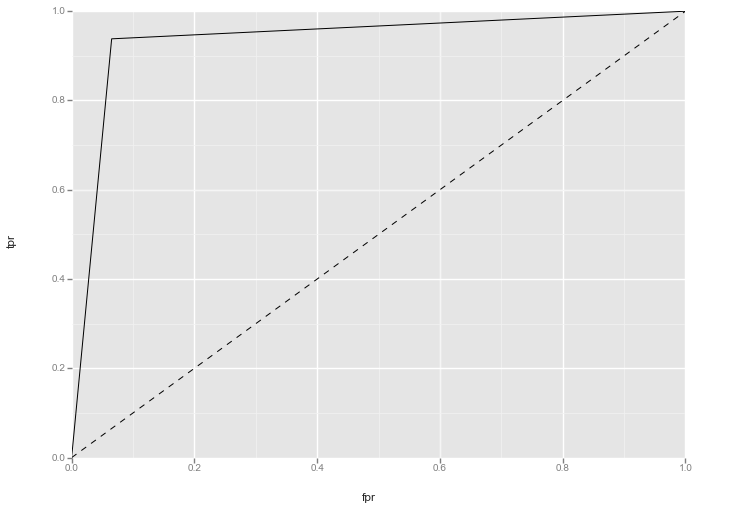

<ggplot: (28104904)>

In [182]:
# ROC graph
from ggplot import *
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) +\
    geom_line() +\
    geom_abline(linetype='dashed')
    
# This is a pretty good looking ROC curve - our model is quite accurate

## Lets try estimate a random forest algortithm and see if we can do better 

In [183]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_jobs=2)
clf.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=2, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [184]:
rf_preds = clf.predict(X_test)

## Feature Importance

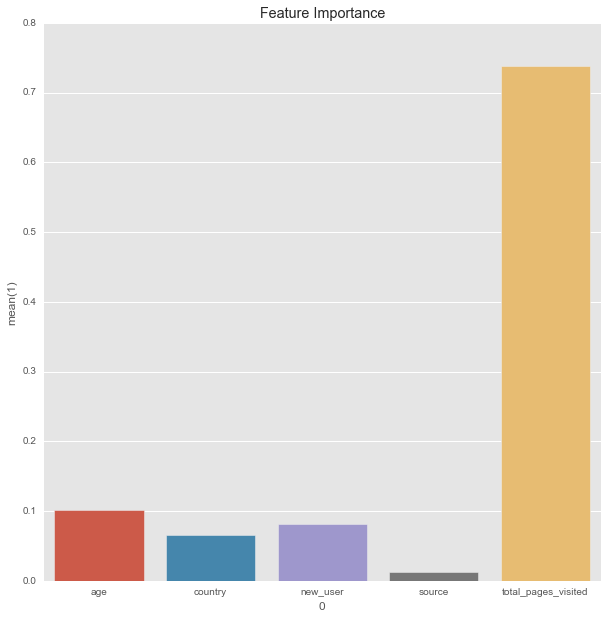

In [185]:
## plot feature importance
temp1 = pd.DataFrame(zip(X_train, clf.feature_importances_))

feat_plot = sns.barplot(temp1[0], temp1[1]).set_title('Feature Importance')

## Clearly total_pages_visited is the most important determinant of whether someone converts or not followed by age and whether they are a new user or not. Source appears be bascially irrelelvant which is basically what we confirmed with our EDA plotting earlier

## What if we estimate a model without the total_pages_visited variable

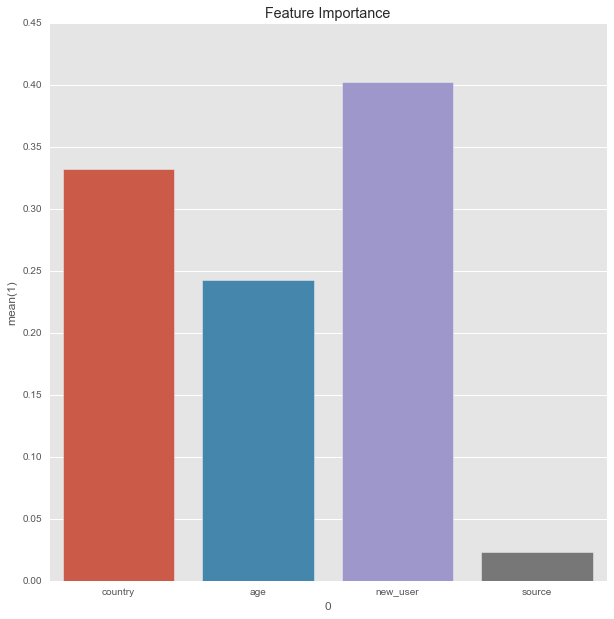

In [195]:
features2 = ['country','age', 'new_user', 'source']
from sklearn.ensemble import RandomForestClassifier
clf2 = RandomForestClassifier(n_jobs=2)
clf2.fit(X_train[features2], y_train)

rf_preds = clf2.predict(X_test[features2])

## plot feature importance
temp2 = pd.DataFrame(zip(X_train[features2], clf2.feature_importances_))

feat_plot2 = sns.barplot(temp2[0], temp2[1]).set_title('Feature Importance')

## We can see that now new_user becomes the most important and then country followed by age. 

# How do we Interpret the results and what are our recommendations based on these results.

## Now I will try and sum up what these results tell us. Remember our goal was to predict the conversion rate and then provide recommendations for the product and market team for our imaginary business to improve the overall conversion rate.

1. We have come up with two models that predicts conversion rate - logistic regression and random forests. The random forest model is marginally better in terms of accuracy.
2. What recommendations can we make:
    * Firstly, the conversion rate is higher for younger users. This suggests that targeting younger users would be an optimal way of trying trying to increase conversion rate. We could look into why this might be the case. Is the website difficult to use for example?
    * Secondly, Conversion rates are higher for German users, however, there are not alot of them.Perhaps trying to increase the number of German users would improve conversion rates.
    * Given the relatively low conversion rate in China. perhaps there is a simple remedy causing users to not convert. The median age in China seems to be higher so perhaps targeting younger people in China may present an opportunity. In terms of the number of user it represents a significant portion so this could very well be a good opportunity to increase conversion rates. 
    * Users with older accounts have a much higher rate of conversion so perhaps providing some sort of benefits to old user could improve rates.
    * Also if people have visited a large number of pages they are likely to convert - perhaps showing them deals or discounts they will convert
